# Model-Based Transfer Learning

<center>
<figure>
<img src="../_static/images/flowers.jpg" alt="flowers">
    <figcaption>Daisy picture (source: <a href=https://www.kaggle.com/datasets/alxmamaev/flowers-recognition>flowers dataset</a>)</figcaption>
</figure>
</center>

In many machine learning cases, the learner has access to a very small amount of labeled data. This is the case for example in radiology when we want to learn a tumor classification task from X-ray images. The number of images available will be very small compared to the complexity of the task. On the other hand, there are very large labeled image datasets like [ImageNet](https://image-net.org/) on which huge neural networks have been pre-trained to classify different types of items. Although ImageNet items differ significantly from X-ray images, the features extracted by a neural network on both task will be more or less the same (filters, contour, contrast...). Thus, a widely used transfer learning method consists in transferring pre-trained networks on particular datasets.

In this type of transfer, the learner has access to a $f_S$ source model with parameters $\beta_S$ (for example a large [ResNet50](https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet50/ResNet50) neural network) which has been trained on a source dataset $(X_S, y_S)$ which is no longer available (for computing power or confidentiality reasons for example). This is called "source-free domain adaptation" or "model-based transfer" (see the [Classification of transfer methods](https://adapt-python.github.io/adapt/map.html)). In most cases, a small set of labeled target data $(X_T, y_T)$ is available. The goal is then to specify $f_S$ on $(X_T, y_T)$ by modifying the $\beta_S$ parameters. This is called *fine-tuning*. In general this approach is more efficient than learning a $f_T$ model directly on $(X_T, y_T)$ (with few data we lack information).

Here, we will study this type of transfer on a case of flowers classification. We use the [flowers dataset](https://www.kaggle.com/datasets/alxmamaev/flowers-recognition) and transfer methods from the [ADAPT library](https://github.com/adapt-python/adapt). We will see how to use ADAPT deep transfer methods on an image dataset.

In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image

2023-06-29 13:29:51.532792: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-29 13:29:51.648205: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-06-29 13:29:52.023766: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-06-29 13:29:52.023812: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

In [2]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(tf.__version__)
print(tf.test.gpu_device_name())
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

2.10.1
/device:GPU:0
Num GPUs Available:  2


2023-06-29 13:29:54.512148: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-29 13:29:54.693171: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-29 13:29:54.693408: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-29 13:29:54.694109: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

First, you have to download the dataset [here](https://www.kaggle.com/datasets/alxmamaev/flowers-recognition). Then store it in a path folder specified by `path_to_flower_dataset`. The dataset contains 5 different flower classes: daisy, dandelion, rose, sunflower and tulip.

As the dataset is too big to fit in RAM on the notebook, we will use the [dataset generator of Tensorflow](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) to fetch the images in the folder at each batch. For this we will create the list of path to the images and the list of labels.

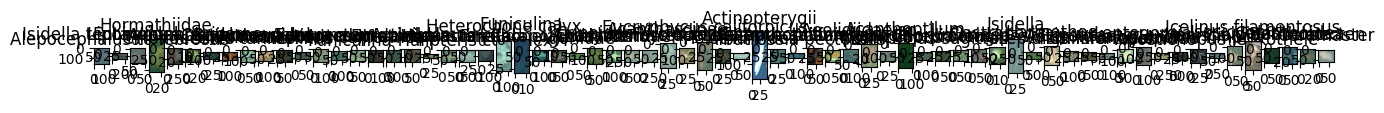

In [3]:
path = "/nvme-pool/bil/kaggle1/train/images/" # path to the downloaded flowers dataset

X_path = []
y = []

fig, axes = plt.subplots(1, 68, figsize=(16, 70))
i = 0
for r, d, f in os.walk(path):
    for direct in d:
        if not ".ipynb_checkpoints" in direct:
            for r, d, f in os.walk(os.path.join(path , direct)):
                for file in f:
                    path_to_image = os.path.join(r, file)
                    if not ".ipynb_checkpoints" in path_to_image:
                        X_path.append(path_to_image)
                        y.append(direct)
            axes[i].imshow(plt.imread(X_path[-1]))
            axes[i].set_title(y[-1])
            i+=1
plt.show()

We will now onehotencode the labels and create two index sets for train and test. We consider that the learner has access to a small train dataset of 20% of the total dataset, that corresponds to 863 data.

In [4]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

one = OneHotEncoder(sparse=False) # is a class with a constructor asking for the sparse - convert cat data to numerical vectors - stored as dense arrays - sparse = False and not as sparse matrices little memory consuming but easier manipulation
y_lab = one.fit_transform(np.array(y).reshape(-1, 1)) #fit_transform convert the director labels in y - numerical vectors, creates a numpy array and its a column vector reshaped by (-1, 1) -1 = numpy figures out on its own the dimension and convert to a column vector 
# given by the second 1

np.random.seed(0) #the random number = 0 gives a set of random numbers which is always the same set allowing reproducebility of the code
train_indexes, test_indexes = train_test_split(np.arange(len(X_path)), train_size=0.2, shuffle=True) #train_test_split function splits the indices of the X_paths to 2 training and test set. the np.arragne makes a array with the length of X_paths and the train_size = 20%
#means that from the split 20% will be used for training, Shuffle = true means the indices of the X_paths are randomly mixed before splitting
print("Train size: %i, Test size: %i"%(len(train_indexes), len(test_indexes))) #%i means the - an integer is being fed to print

Train size: 603, Test size: 2414


/home/varshani/Documents/DA/.venv/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


As we have said before, the whole image dataset might take too much space in RAM, so we create two dataset generators that fetch the data from the path and preprocess in the ResNet50 format. We also create a load function for the ResNet, in this function we set the `trainable` parameter of the `BatchNormalizationLayer` to `False` to avoid problems later during fine-tuning (see the [Tensorflow documentation](https://www.tensorflow.org/tutorials/images/transfer_learning) about the issue with BatchNormalization). We don't take the last layer of the ResNet which is used to give the classes, because the ResNet has not been trained to classify between the 5 classes of flowers.

In [11]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.models import load_model

def generator_train(only_X=False):
    for i in train_indexes:
        image = Image.open(X_path[i])
        image = image.resize((224, 224), Image.ANTIALIAS)
        X = np.array(image, dtype=int)
        if only_X:
            yield preprocess_input(X)
        else:
            yield (preprocess_input(X), y_lab[i])

def generator_test(only_X=False):
    for i in test_indexes:
        image = Image.open(X_path[i])
        image = image.resize((224, 224), Image.ANTIALIAS)
        X = np.array(image, dtype=int)
        if only_X:
            yield preprocess_input(X)
        else:
            yield (preprocess_input(X), y_lab[i])
        
data_train = tf.data.Dataset.from_generator(generator_train,
                                        output_types=(tf.float32, tf.float32),
                                        output_shapes=([224,224,3], [68])) # the 5 represents 5 classes. so if you want to run more classes change this first

data_test = tf.data.Dataset.from_generator(generator_test,
                                        output_types=(tf.float32, tf.float32),
                                        output_shapes=([224,224,3], [68]))

X_train = tf.data.Dataset.from_generator(generator_train, args=(True,),
                                        output_types=tf.float32,
                                        output_shapes=[224,224,3])

X_test = tf.data.Dataset.from_generator(generator_test, args=(True,),
                                        output_types=tf.float32,
                                        output_shapes=[224,224,3])

def load_resnet50(path="resnet50.hdf5"):
    model = ResNet50(include_top=False, input_shape=(224, 224, 3), pooling="avg") #include_top = False - means the last layer of the model is not executed because we want to make our own changes to that layer, pooling= avg
    for i in range(len(model.layers)):
        if model.layers[i].__class__.__name__ == "BatchNormalization":
            model.layers[i].trainable = False
    return model

## Training a model from scratch

To get an idea of the potential gain of using transfer, we will first look at the perfroamnces that can be obtained by training a model using only the 863 flowers data that we have. We will create a convolutional model and train it on this small training dataset.

In [35]:
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Input, Dropout, Conv2D, MaxPooling2D, Layer
from tensorflow.keras.layers import Flatten, Reshape, BatchNormalization
from tensorflow.keras.optimizers import Adam

class Rescaling(Layer):
    
    def __init__(self, scale=1., offset=0.):
        super().__init__()
        self.scale = scale
        self.offset = offset
        
    def call(self, inputs):
        return inputs*self.scale + self.offset


def get_model(input_shape=(224, 224, 3)):
    inputs = Input(input_shape)
    modeled = Rescaling(1./127.5, offset=-1.0)(inputs)
    modeled = Conv2D(32, 5, activation='relu')(modeled)
    modeled = MaxPooling2D(2, 2)(modeled)
    modeled = BatchNormalization()(modeled)
    modeled = Conv2D(48, 5, activation='relu')(modeled)
    modeled = BatchNormalization()(modeled)
    modeled = MaxPooling2D(2, 2)(modeled)
    modeled = Conv2D(64, 5, activation='relu')(modeled)
    modeled = BatchNormalization()(modeled)
    modeled = MaxPooling2D(2, 2)(modeled)
    modeled = Conv2D(128, 5, activation='relu')(modeled)
    modeled = BatchNormalization()(modeled)
    modeled = MaxPooling2D(2, 2)(modeled)
    modeled = Flatten()(modeled)
    modeled = Dropout(0.5)(modeled)
    modeled = Dense(5, activation="softmax")(modeled)
    model = Model(inputs, modeled)
    model.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=["acc"])
    return model

model = get_model()
model.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
rescaling_3 (Rescaling)      (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 220, 220, 32)      2432      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 110, 110, 32)      0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 110, 110, 32)      128       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 106, 106, 48)      38448     
_________________________________________________________________
batch_normalization_13 (Batc (None, 106, 106, 48)     

In [24]:
model.fit(data_train.batch(32), epochs=20, validation_data=data_test.batch(32))

Epoch 1/20
27/27 [==============================] - 120s 4s/step - loss: 2.8724 - acc: 0.3835 - val_loss: 4.0791 - val_acc: 0.1667
Epoch 2/20
27/27 [==============================] - 104s 4s/step - loss: 2.2739 - acc: 0.4705 - val_loss: 2.9788 - val_acc: 0.3080
Epoch 3/20
27/27 [==============================] - 105s 4s/step - loss: 2.0500 - acc: 0.5342 - val_loss: 1.9133 - val_acc: 0.3540
Epoch 4/20
27/27 [==============================] - 107s 4s/step - loss: 1.5245 - acc: 0.5979 - val_loss: 1.7637 - val_acc: 0.4295
Epoch 5/20
27/27 [==============================] - 106s 4s/step - loss: 1.2288 - acc: 0.6802 - val_loss: 2.0211 - val_acc: 0.4379
Epoch 6/20
27/27 [==============================] - 103s 4s/step - loss: 1.0851 - acc: 0.6825 - val_loss: 2.2675 - val_acc: 0.4370
Epoch 7/20
27/27 [==============================] - 105s 4s/step - loss: 1.0882 - acc: 0.7034 - val_loss: 2.4987 - val_acc: 0.4356
Epoch 8/20
27/27 [==============================] - 101s 4s/step - loss: 0.9022 - a

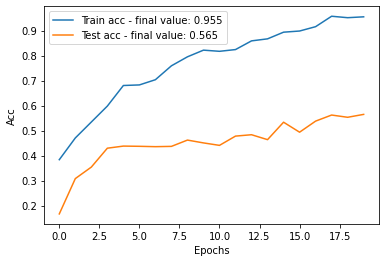

In [28]:
acc = model.history.history["acc"]; val_acc = model.history.history["val_acc"]
plt.plot(acc, label="Train acc - final value: %.3f"%acc[-1])
plt.plot(val_acc, label="Test acc - final value: %.3f"%val_acc[-1])
plt.legend(); plt.xlabel("Epochs"); plt.ylabel("Acc"); plt.show()

We observe that the performances on the test dataset are not at the level of the train, we have about 57% of accuracy, which is not very satisfactory. There is some overfitting here since the train score reaches 95%, the network we used could perhaps be optimized to increase the test score but we will study here the effect of using a pre-trained model.

## Model-based Transfer

We will now look at what can be obtained by using the ResNet, we will study two ways of transferring:

- Features Extraction**: We use directly the last hidden layer of the ResNet as input features for a new smaller model.
- Fine-Tuning**: We train a new smaller model on top of the ResNet and fine-tune the weights of the ResNet at the same time

We will use a neural network with two hidden layers of 1024 neurons as task network after the ResNet, the last layer has 5 neurons for the 5 classes.

In [29]:
def get_task():
    model = Sequential()
    model.add(Dense(1024, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(1024, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(5, activation="softmax"))
    return model

### Features Extraction

We create two data sets `X_train_enc` and `X_test_enc` from the outputs of the ResNet:

In [41]:
resnet50 = load_resnet50()
X_train_enc = resnet50.predict(X_train.batch(32))
X_test_enc = resnet50.predict(X_test.batch(32))

print("X train shape: %s"%str(X_train_enc.shape))

X train shape: (863, 2048)


Let's fit then a `task` network on the train set:

In [39]:
task = get_task()
task.compile(loss="categorical_crossentropy", optimizer=Adam(0.001), metrics=["acc"])
task.fit(X_train_enc, y_lab[train_indexes], epochs=20, batch_size=32,
         validation_data=(X_test_enc, y_lab[test_indexes]))

Epoch 1/20
27/27 [==============================] - 1s 34ms/step - loss: 1.2552 - acc: 0.6257 - val_loss: 0.4388 - val_acc: 0.8495
Epoch 2/20
27/27 [==============================] - 1s 26ms/step - loss: 0.4964 - acc: 0.8297 - val_loss: 0.3922 - val_acc: 0.8692
Epoch 3/20
27/27 [==============================] - 1s 28ms/step - loss: 0.3568 - acc: 0.8806 - val_loss: 0.4007 - val_acc: 0.8703
Epoch 4/20
27/27 [==============================] - 1s 27ms/step - loss: 0.2544 - acc: 0.9154 - val_loss: 0.3593 - val_acc: 0.8868
Epoch 5/20
27/27 [==============================] - 1s 25ms/step - loss: 0.1809 - acc: 0.9351 - val_loss: 0.4353 - val_acc: 0.8729
Epoch 6/20
27/27 [==============================] - 1s 26ms/step - loss: 0.1650 - acc: 0.9409 - val_loss: 0.3978 - val_acc: 0.8906
Epoch 7/20
27/27 [==============================] - 1s 26ms/step - loss: 0.1290 - acc: 0.9594 - val_loss: 0.3897 - val_acc: 0.8874
Epoch 8/20
27/27 [==============================] - 1s 26ms/step - loss: 0.0938 - a

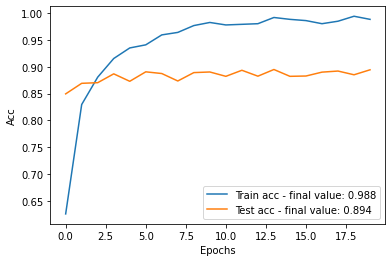

In [40]:
acc = task.history.history["acc"]; val_acc = task.history.history["val_acc"]
plt.plot(acc, label="Train acc - final value: %.3f"%acc[-1])
plt.plot(val_acc, label="Test acc - final value: %.3f"%val_acc[-1])
plt.legend(); plt.xlabel("Epochs"); plt.ylabel("Acc"); plt.show()

You can clearly see that the results obtained are much better: 0.89% of accuracy instead of 0.57%! We can say that the features extracted from the ResNet50 make sense for our set of flower images. As the ResNet has been trained on a large dataset we can also consider that the features of the last layer are more general which leads to reduce the overfitting.

### Fine-Tuning

Previously, we have fixed the parameters of the ResNet50, we will see if a gain is possible by fine-tuning them with respect to the flower classification task. Note that we don't want to change completely the parameters of the ResNet because otherwise we lose the information of the sources and we come back to a target only model and thus to the risk of overfitting. This is why we will update the ResNet parameters more slowly than those of the task model. We will also pre-train the task model with the ResNet parameters fixed to avoid that the first updates of the ResNet are made using the gradients returned by a poor task model.

We will use the [FineTuning](https://adapt-python.github.io/adapt/generated/adapt.parameter_based.FineTuning.html) object of the ADAPT library which allows to easily implement such a finetuning.
Note that we could use directly the `task` model that we have just trained above, but to see how to use FineTuning directly we will do a pre-training.

In [42]:
from adapt.parameter_based import FineTuning

encoder = load_resnet50()
task = get_task()

optimizer = Adam(0.001)
optimizer_enc = Adam(0.00001)

finetunig = FineTuning(encoder=encoder,
                         task=task,
                         optimizer=optimizer,
                         optimizer_enc=optimizer_enc,
                         loss="categorical_crossentropy",
                         metrics=["acc"],
                         copy=False,
                         pretrain=True,
                         pretrain__epochs=10)

As we can see above, we need to define an `encoder` network (our ResNet) which will do the feature extraction and a `task` network. We define two optimizers: `optimizer_enc` for the encoder and `òptimizer` for the task. We take a much smaller learning rate for `optimizer_enc`, here we took 100 times less. To specify that we want to pre-train the `task` model on the fixed encoder, we set the `pretrain` parameter to `True`, then we specify the number of pre-training epochs with the `pretrain__epochs` parameter. We also specify the loss and the metrics. Notice that we set the parameter `copy` to `False` to avoid a copy of the ResNet which would increase the memory usage for no reason.

In [43]:
finetunig.fit(data_train, epochs=10, batch_size=32, validation_data=data_test.batch(32))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch 1/10
27/27 [==============================] - 194s 7s/step - loss: 1.2252 - acc: 0.6176 - val_loss: 0.5543 - val_acc: 0.8014
Epoch 2/10
27/27 [==============================] - 203s 8s/step - loss: 0.4900 - acc: 0.8482 - val_loss: 0.4472 - val_acc: 0.8452
Epoch 3/10
27/27 [==============================] - 201s 7s/step - loss: 0.3342 - acc: 0.8830 - val_loss: 0.4226 - val_acc: 0.8669
Epoch 4/10
27/27 [==============================] - 197s 7s/step - loss: 0.2531 - acc: 0.9050 - val_loss: 0.3568 - 

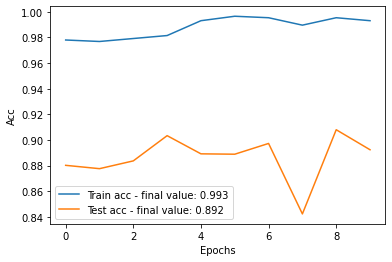

In [44]:
acc = finetunig.history.history["acc"]; val_acc = finetunig.history.history["val_acc"]
plt.plot(acc, label="Train acc - final value: %.3f"%acc[-1])
plt.plot(val_acc, label="Test acc - final value: %.3f"%val_acc[-1])
plt.legend(); plt.xlabel("Epochs"); plt.ylabel("Acc"); plt.show()

We observe that the finetuned network performs better than the network trained from scratch, however the performances are not really higher than the one of the feature-extraction method. In some cases the features given by the ResNet are already very good, by modifying them we take the risk to lose in generalization, here the flower dataset is quite close to the ImageNet dataset but in other cases (as X-ray images) it can be interesting to modify the ResNet.